In [1]:
import sys
sys.path.append("../../src")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from exact_solution import solve_master_equation, one_excited_emitter_state

In [2]:
aqt_results = pd.read_csv("./QMarina-AQT-4Q.csv", index_col=0)
aqt_results = aqt_results.set_index(["Time", "Protocol", "Randomizations", "Identities"])

aqt_bitstrs = {
    "Emitter 1": "1000",
    "Emitter 2": "0100",
    "Emitter 3": "0001",
    "Cavity + Environment": "0010",
}

In [3]:
N = 3
g = 4
kappa = 2
times = np.linspace(0, 3, 51)

In [4]:
initial_state = one_excited_emitter_state(N, 1)
qutip_results = solve_master_equation(N, g, kappa, initial_state, times)

In [5]:
rms = {
    "Emitter 1": [],
    "Emitter 2": [],
    "Emitter 3": [],
    "Cavity + Environment": [],
}

mae = {
    "Emitter 1": [],
    "Emitter 2": [],
    "Emitter 3": [],
    "Cavity + Environment": [],
}

# Raw

## RMS and MAE

Emitter 1 RMS 1.4502429304615068
Emitter 2 RMS 0.3189974730165633
Emitter 3 RMS 0.43880275598337465
Cavity + Environment RMS 0.6095877825439562


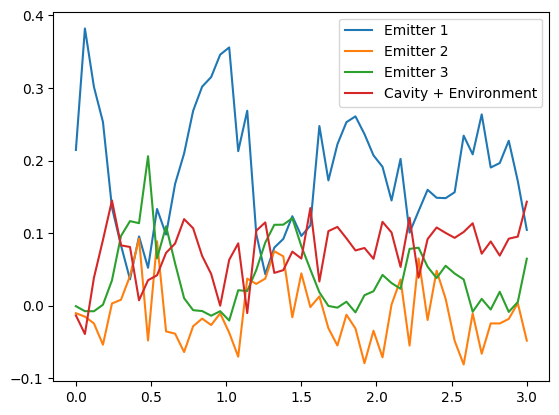

In [6]:
raw_data = aqt_results.xs("RAW", level="Protocol")

for col, bitstr in aqt_bitstrs.items():
    diff = qutip_results[col] - np.array(raw_data[bitstr])
    print(col, "RMS", np.sqrt(np.sum(diff**2)))
    rms[col].append(np.sqrt(np.sum(diff**2)))
    mae[col].append(np.mean(np.abs(diff)))
    plt.plot(times, diff, label=col)

plt.legend()

## Fourier

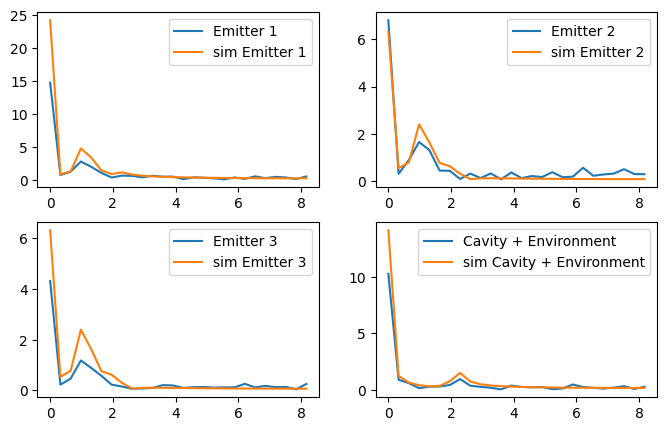

In [7]:
raw_data = aqt_results.xs("RAW", level="Protocol")
n = len(raw_data)
fig, axes = plt.subplots(2, 2, figsize=(8, 5))

for (col, bitstr), ax in zip(aqt_bitstrs.items(), axes.flatten()):
    fft = np.fft.rfft(raw_data[bitstr], n)
    freqs = np.fft.rfftfreq(n, times[1] - times[0])
    ax.plot(freqs, np.abs(fft), label=col)

    fft = np.fft.rfft(qutip_results[col], n)
    freqs = np.fft.rfftfreq(n, times[1] - times[0])
    ax.plot(freqs, np.abs(fft), label="sim " + col)

    ax.legend()

# Raw normed

## RMS and MAE

In [8]:
raw_data_norm = raw_data.copy()
raw_data_norm[['1000', '0100', '0010', '0001']] = raw_data_norm[['1000', '0100', '0010', '0001']].divide(raw_data_norm[['1000', '0100', '0010', '0001']].sum(axis=1), axis=0)
raw_data_norm['avg_0100_0010'] = raw_data_norm[['0100', '0010']].mean(axis=1)

Emitter 1 RMS 0.6080168250710373
Emitter 2 RMS 0.5520578951942797
Emitter 3 RMS 0.27492574544996645
Cavity + Environment RMS 0.330786839693802


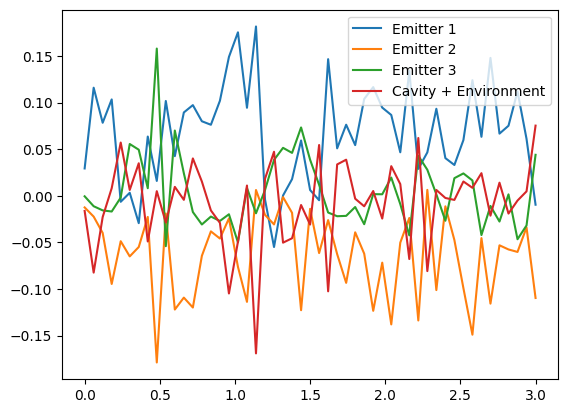

In [9]:
for col, bitstr in aqt_bitstrs.items():
    diff = qutip_results[col] - np.array(raw_data_norm[bitstr])
    print(col, "RMS", np.sqrt(np.sum(diff**2)))
    rms[col].append(np.sqrt(np.sum(diff**2)))
    mae[col].append(np.mean(np.abs(diff)))
    plt.plot(times, diff, label=col)

plt.legend()

## Fourier

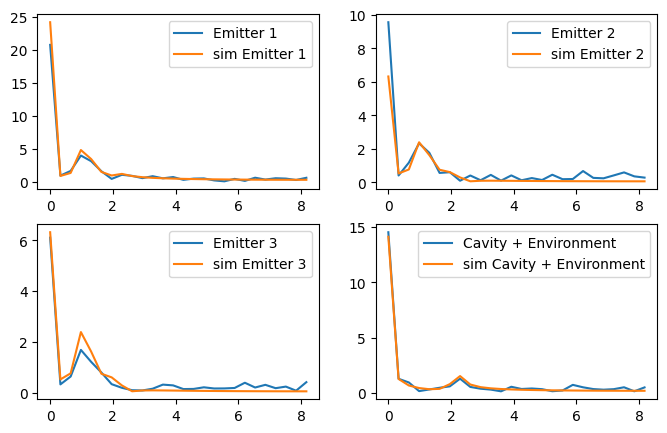

In [10]:
n = len(raw_data_norm)
fig, axes = plt.subplots(2, 2, figsize=(8, 5))

for (col, bitstr), ax in zip(aqt_bitstrs.items(), axes.flatten()):
    fft = np.fft.rfft(raw_data_norm[bitstr], n)
    freqs = np.fft.rfftfreq(n, times[1] - times[0])
    ax.plot(freqs, np.abs(fft), label=col)

    fft = np.fft.rfft(qutip_results[col], n)
    freqs = np.fft.rfftfreq(n, times[1] - times[0])
    ax.plot(freqs, np.abs(fft), label="sim " + col)

    ax.legend()

# RC

## RMS and MAE

Emitter 1 RMS 1.0893698028745928
Emitter 2 RMS 0.2922930459381406
Emitter 3 RMS 0.3164728013808656
Cavity + Environment RMS 0.5645014004301556
Emitter 1 RMS 1.0769224594131854
Emitter 2 RMS 0.3130266569150834
Emitter 3 RMS 0.31659467509240313
Cavity + Environment RMS 0.5766455235902694


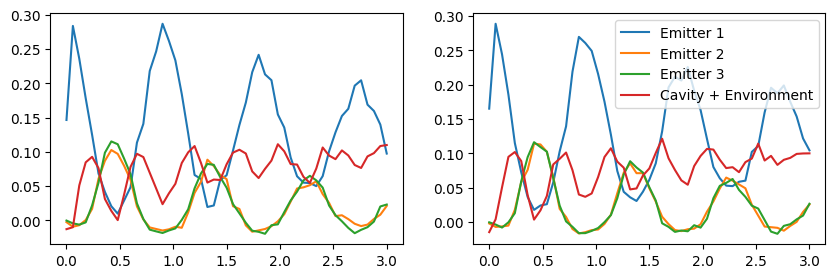

In [11]:
rc_data = aqt_results.xs("RC", level="Protocol")
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

for num_rand, ax in zip([40, 80], axes):
    for col, bitstr in aqt_bitstrs.items():
        data = rc_data.xs(num_rand, level="Randomizations")
        diff = qutip_results[col] - np.array(data[bitstr])
        print(col, "RMS", np.sqrt(np.sum(diff**2)))
        rms[col].append(np.sqrt(np.sum(diff**2)))
        mae[col].append(np.mean(np.abs(diff)))
        ax.plot(times, diff, label=col)

plt.legend()

## Fourier

/var/folders/ds/t6zgkw3n75d3gzz89xmkcncm0000gn/T/ipykernel_65965/2375254708.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


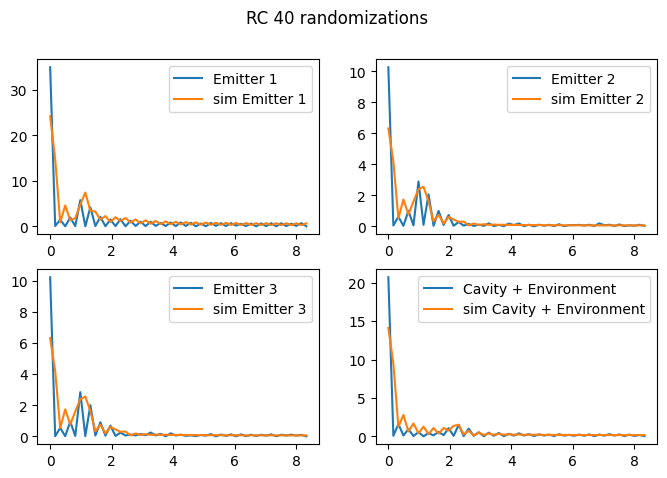

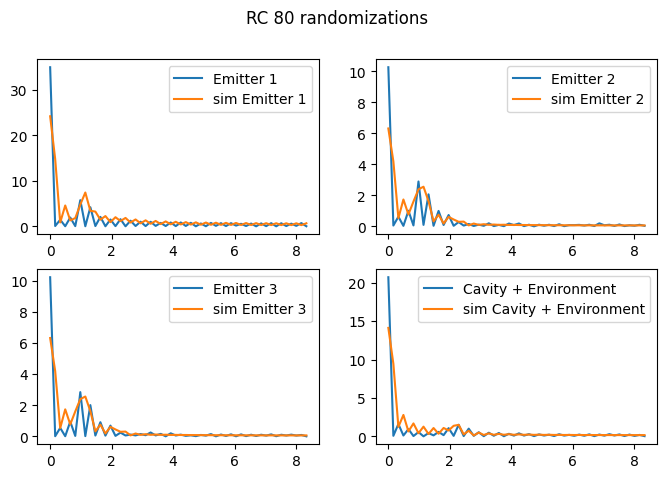

In [12]:
n = len(rc_data)

for num_rand, ax in zip([40, 80], axes):
    fig, axes = plt.subplots(2, 2, figsize=(8, 5))
    fig.suptitle(f"RC {num_rand} randomizations")

    for (col, bitstr), ax in zip(aqt_bitstrs.items(), axes.flatten()):
        fft = np.fft.rfft(rc_data[bitstr], n)
        freqs = np.fft.rfftfreq(n, times[1] - times[0])
        ax.plot(freqs, np.abs(fft), label=col)

        fft = np.fft.rfft(qutip_results[col], n)
        freqs = np.fft.rfftfreq(n, times[1] - times[0])
        ax.plot(freqs, np.abs(fft), label="sim " + col)

        ax.legend()
    
    fig.show()

# normed RC

## RMS and MAE

Emitter 1 RMS 0.31795350254107285
Emitter 2 RMS 0.15791766062671683
Emitter 3 RMS 0.18050628069149469
Cavity + Environment RMS 0.14103570668243184
Emitter 1 RMS 0.3030010670352208
Emitter 2 RMS 0.16557278988368224
Emitter 3 RMS 0.17201677949481622
Cavity + Environment RMS 0.14305397479065507


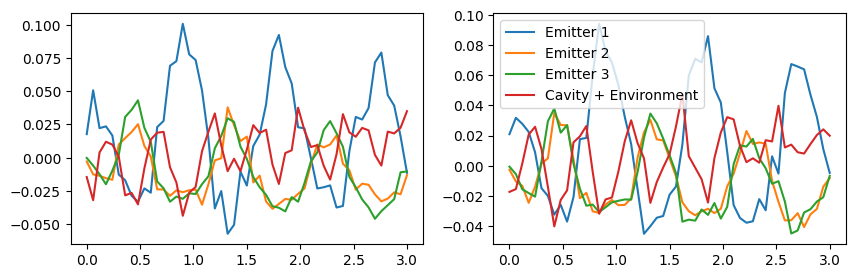

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

for num_rand, ax in zip([40, 80], axes):
    data = rc_data.xs(num_rand, level="Randomizations")

    rc_data_norm = data.copy()
    rc_data_norm[['1000', '0100', '0010', '0001']] = rc_data_norm[['1000', '0100', '0010', '0001']].divide(rc_data_norm[['1000', '0100', '0010', '0001']].sum(axis=1), axis=0)
    rc_data_norm['avg_0100_0010'] = rc_data_norm[['0100', '0010']].mean(axis=1)

    for col, bitstr in aqt_bitstrs.items():
        diff = qutip_results[col] - np.array(rc_data_norm[bitstr])
        print(col, "RMS", np.sqrt(np.sum(diff**2)))
        rms[col].append(np.sqrt(np.sum(diff**2)))
        mae[col].append(np.mean(np.abs(diff)))
        ax.plot(times, diff, label=col)

plt.legend()

## Fourier

/var/folders/ds/t6zgkw3n75d3gzz89xmkcncm0000gn/T/ipykernel_65965/3319259109.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


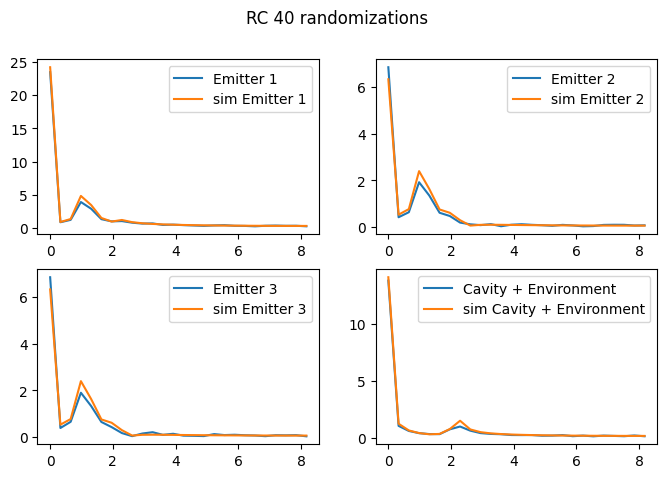

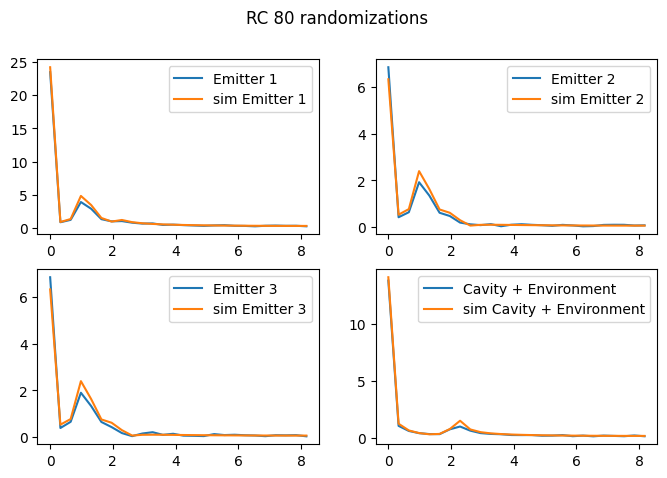

In [14]:
n = len(rc_data_norm)

for num_rand, ax in zip([40, 80], axes):
    fig, axes = plt.subplots(2, 2, figsize=(8, 5))
    fig.suptitle(f"RC {num_rand} randomizations")

    for (col, bitstr), ax in zip(aqt_bitstrs.items(), axes.flatten()):
        fft = np.fft.rfft(rc_data_norm[bitstr], n)
        freqs = np.fft.rfftfreq(n, times[1] - times[0])
        ax.plot(freqs, np.abs(fft), label=col)

        fft = np.fft.rfft(qutip_results[col], n)
        freqs = np.fft.rfftfreq(n, times[1] - times[0])
        ax.plot(freqs, np.abs(fft), label="sim " + col)

        ax.legend()
    
    fig.show()

# RC + NOX

## RMS and MAE

Emitter 1 RMS 0.6904460422330536
Emitter 2 RMS 0.4485357407743916
Emitter 3 RMS 0.3118983517551639
Cavity + Environment RMS 0.4520841589404127
Emitter 1 RMS 0.4589501507391201
Emitter 2 RMS 0.25850643441043275
Emitter 3 RMS 0.20475941961044236
Cavity + Environment RMS 0.30444556856917804
Emitter 1 RMS 0.4351243072908241
Emitter 2 RMS 0.25418552184091026
Emitter 3 RMS 0.18827687165319384
Cavity + Environment RMS 0.2979099104463711
Emitter 1 RMS 0.44385359050269474
Emitter 2 RMS 0.20469949116747976
Emitter 3 RMS 0.17764017174518906
Cavity + Environment RMS 0.2632200557650882
Emitter 1 RMS 0.5297324648205586
Emitter 2 RMS 0.21266654368857205
Emitter 3 RMS 0.18908245721916053
Cavity + Environment RMS 0.2701726075728844


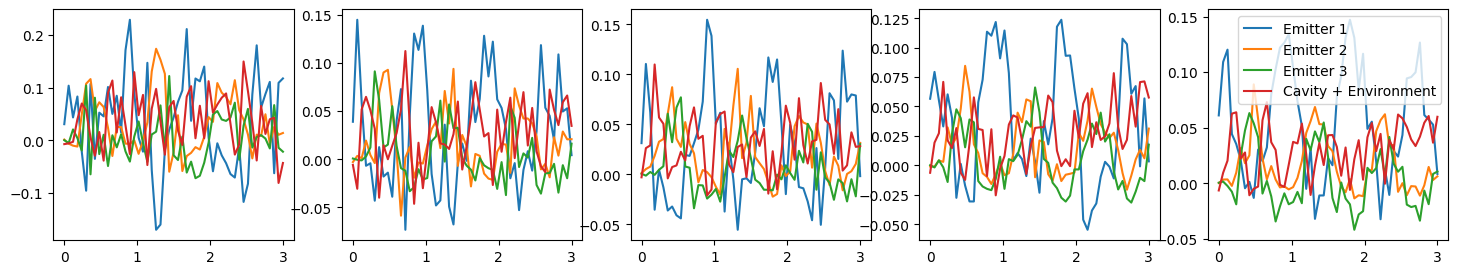

In [15]:
nox_data = aqt_results.xs("NOX", level="Protocol")

fig, axes = plt.subplots(1, 5, figsize=(18, 3))

for num_ident, ax in zip([1, 2, 3, 4, 6], axes):
    for col, bitstr in aqt_bitstrs.items():
        data = nox_data.xs(num_ident, level="Identities")
        diff = qutip_results[col] - np.array(data[bitstr])
        print(col, "RMS", np.sqrt(np.sum(diff**2)))
        rms[col].append(np.sqrt(np.sum(diff**2)))
        mae[col].append(np.mean(np.abs(diff)))
        ax.plot(times, diff, label=col)

plt.legend()

## Fourier

/var/folders/ds/t6zgkw3n75d3gzz89xmkcncm0000gn/T/ipykernel_65965/363087379.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


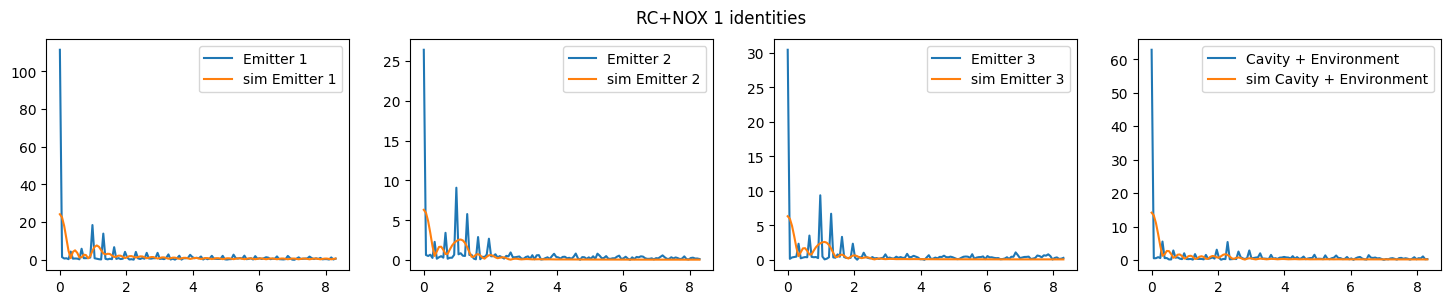

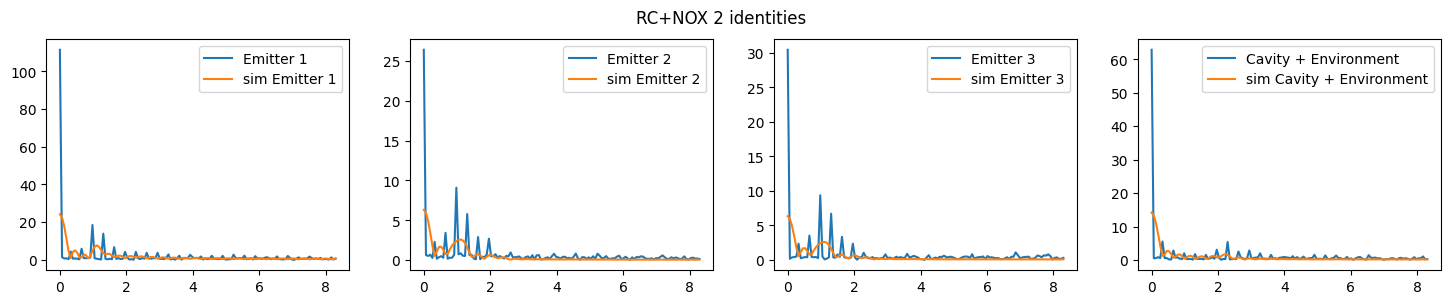

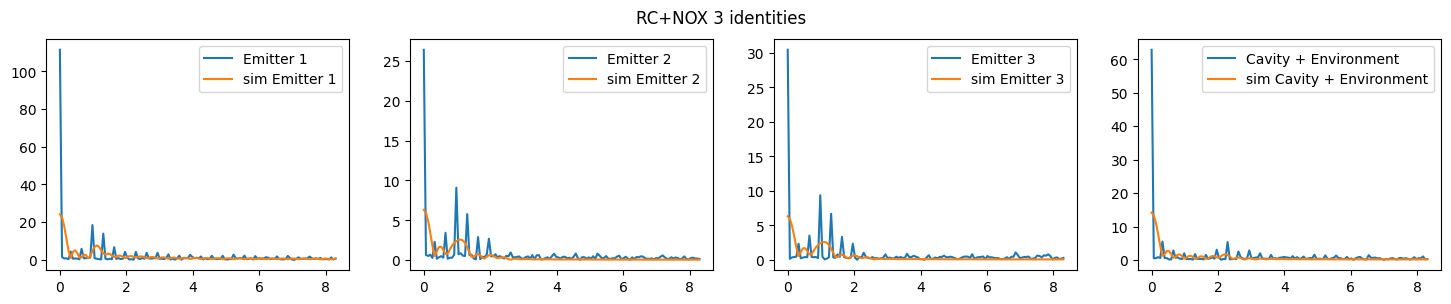

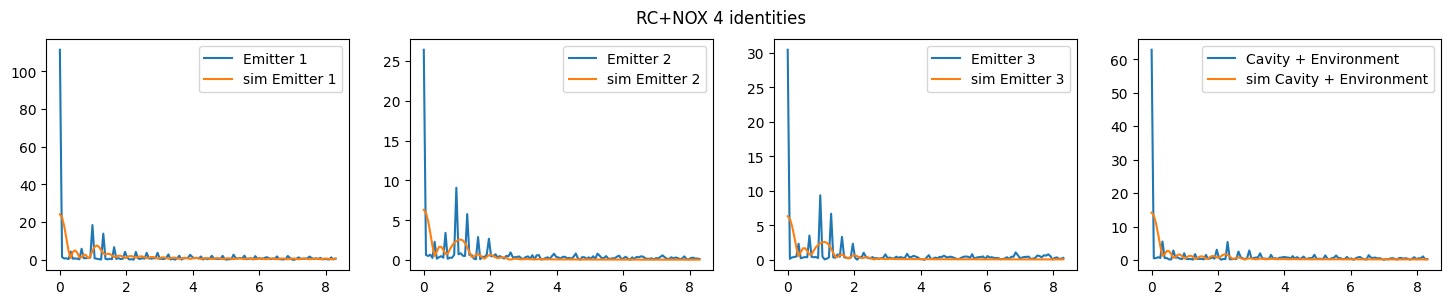

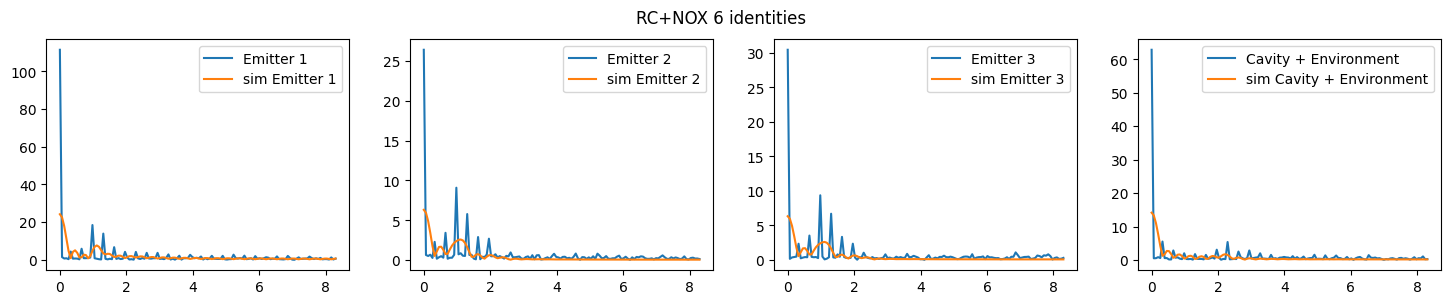

In [16]:
n = len(nox_data)

for num_ident in [1, 2, 3, 4, 6]:
    fig, axes = plt.subplots(1, 4, figsize=(18, 3))

    fig.suptitle(f"RC+NOX {num_ident} identities")

    for (col, bitstr), ax in zip(aqt_bitstrs.items(), axes.flatten()):
        fft = np.fft.rfft(nox_data[bitstr], n)
        freqs = np.fft.rfftfreq(n, times[1] - times[0])
        ax.plot(freqs, np.abs(fft), label=col)

        fft = np.fft.rfft(qutip_results[col], n)
        freqs = np.fft.rfftfreq(n, times[1] - times[0])
        ax.plot(freqs, np.abs(fft), label="sim " + col)

        ax.legend()
    
    fig.show()

# normed RC + NOX

## RMS and MAE

Emitter 1 RMS 0.6683860017073481
Emitter 2 RMS 0.4194082102736274
Emitter 3 RMS 0.3489613344670239
Cavity + Environment RMS 0.36977513509434146
Emitter 1 RMS 0.3557360657929602
Emitter 2 RMS 0.21509738370871295
Emitter 3 RMS 0.19710217137313704
Cavity + Environment RMS 0.23152709474012628
Emitter 1 RMS 0.34045128819264986
Emitter 2 RMS 0.19565638002193
Emitter 3 RMS 0.16419700946764898
Cavity + Environment RMS 0.20765005450517113
Emitter 1 RMS 0.30236089498620405
Emitter 2 RMS 0.15245773115695552
Emitter 3 RMS 0.15438541192481842
Cavity + Environment RMS 0.17229548247316265
Emitter 1 RMS 0.2627197978640465
Emitter 2 RMS 0.14359983071778373
Emitter 3 RMS 0.1705206227607161
Cavity + Environment RMS 0.15178607502507013


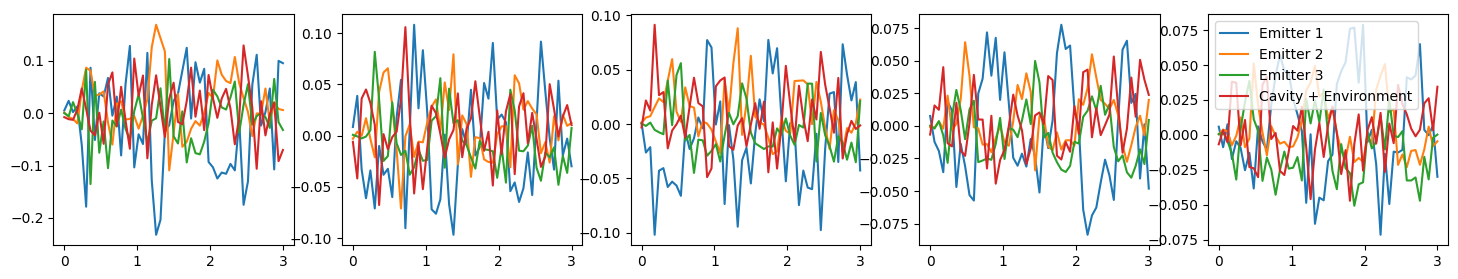

In [17]:
fig, axes = plt.subplots(1, 5, figsize=(18, 3))

for num_ident, ax in zip([1, 2, 3, 4, 6], axes):
    data = nox_data.xs(num_ident, level="Identities")

    nox_data_norm = data.copy()
    nox_data_norm[['1000', '0100', '0010', '0001']] = nox_data_norm[['1000', '0100', '0010', '0001']].divide(nox_data_norm[['1000', '0100', '0010', '0001']].sum(axis=1), axis=0)
    nox_data_norm['avg_0100_0010'] = nox_data_norm[['0100', '0010']].mean(axis=1)

    for col, bitstr in aqt_bitstrs.items():
        diff = qutip_results[col] - np.array(nox_data_norm[bitstr])
        print(col, "RMS", np.sqrt(np.sum(diff**2)))
        rms[col].append(np.sqrt(np.sum(diff**2)))
        mae[col].append(np.mean(np.abs(diff)))
        ax.plot(times, diff, label=col)

plt.legend()

## Fourier

/var/folders/ds/t6zgkw3n75d3gzz89xmkcncm0000gn/T/ipykernel_65965/2811845890.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


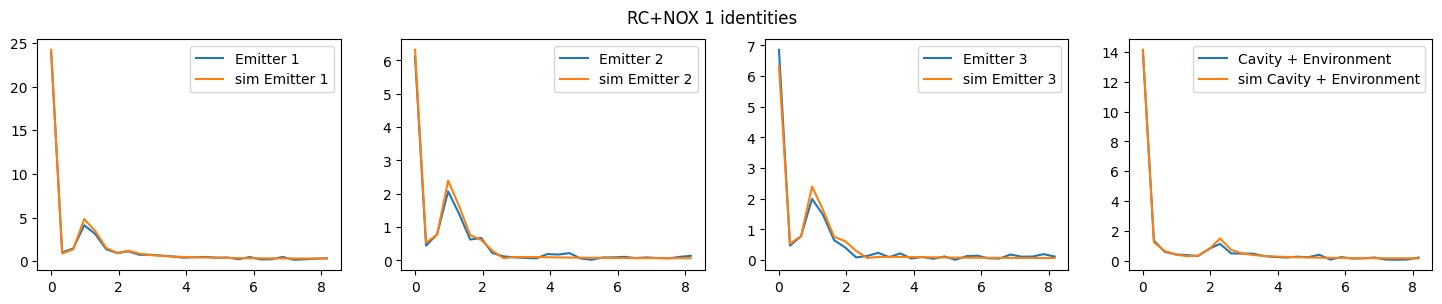

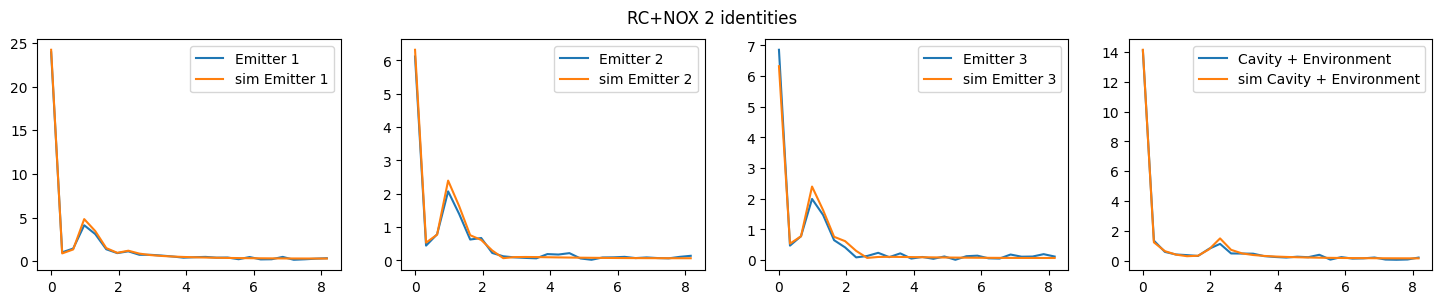

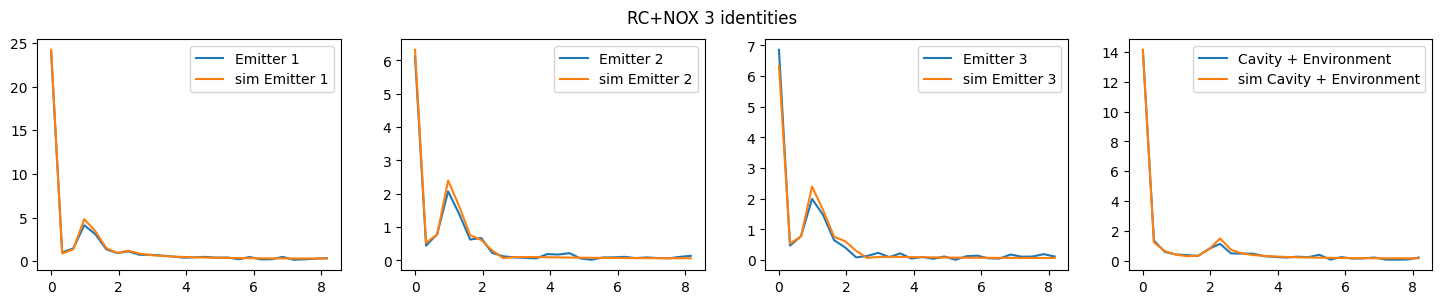

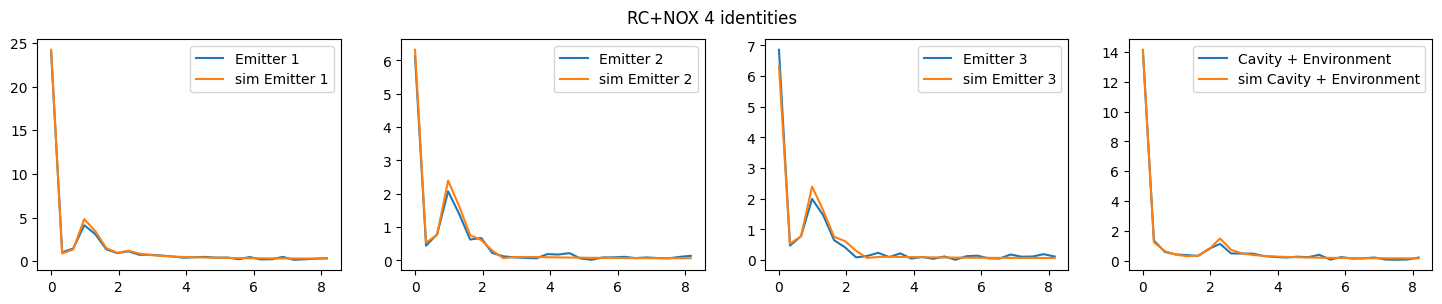

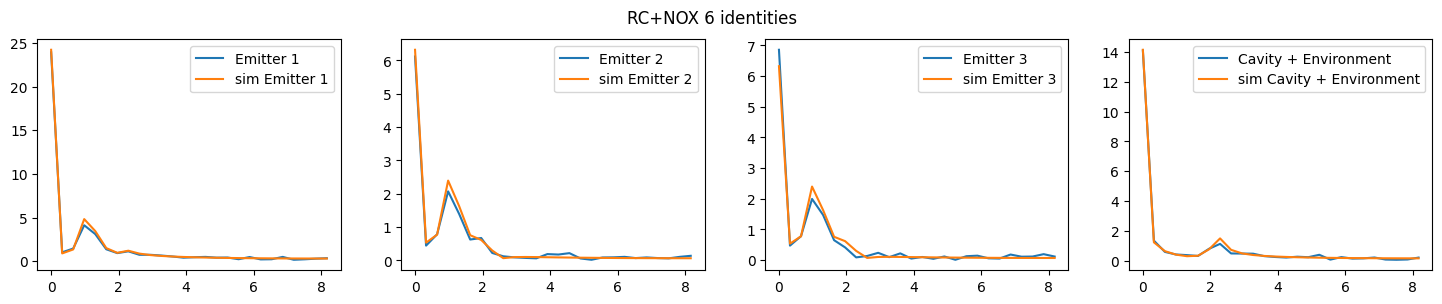

In [18]:
n = len(nox_data_norm)

for num_ident in [1, 2, 3, 4, 6]:
    fig, axes = plt.subplots(1, 4, figsize=(18, 3))

    fig.suptitle(f"RC+NOX {num_ident} identities")

    for (col, bitstr), ax in zip(aqt_bitstrs.items(), axes.flatten()):
        fft = np.fft.rfft(nox_data_norm[bitstr], n)
        freqs = np.fft.rfftfreq(n, times[1] - times[0])
        ax.plot(freqs, np.abs(fft), label=col)

        fft = np.fft.rfft(qutip_results[col], n)
        freqs = np.fft.rfftfreq(n, times[1] - times[0])
        ax.plot(freqs, np.abs(fft), label="sim " + col)

        ax.legend()
    
    fig.show()

# Plot all RMS values

In [19]:
orig_order = [
    "raw",
    "raw_normed",
    "RC 40",
    "RC 80",
    "RC 40 normed",
    "RC 80 normed",
    "NOX 1",
    "NOX 2",
    "NOX 3",
    "NOX 4",
    "NOX 6",
    "NOX 1 normed",
    "NOX 2 normed",
    "NOX 3 normed",
    "NOX 4 normed",
    "NOX 6 normed",
]

new_order = [
    "raw",
    "raw_normed",
    "RC 40",
    "RC 40 normed",
    "RC 80",
    "RC 80 normed",
    "NOX 1",
    "NOX 1 normed",
    "NOX 2",
    "NOX 2 normed",
    "NOX 3",
    "NOX 3 normed",
    "NOX 4",
    "NOX 4 normed",
    "NOX 6",
    "NOX 6 normed",
]

all_rms = pd.DataFrame(rms, index=orig_order).loc[new_order]
all_mae = pd.DataFrame(mae, index=orig_order).loc[new_order]

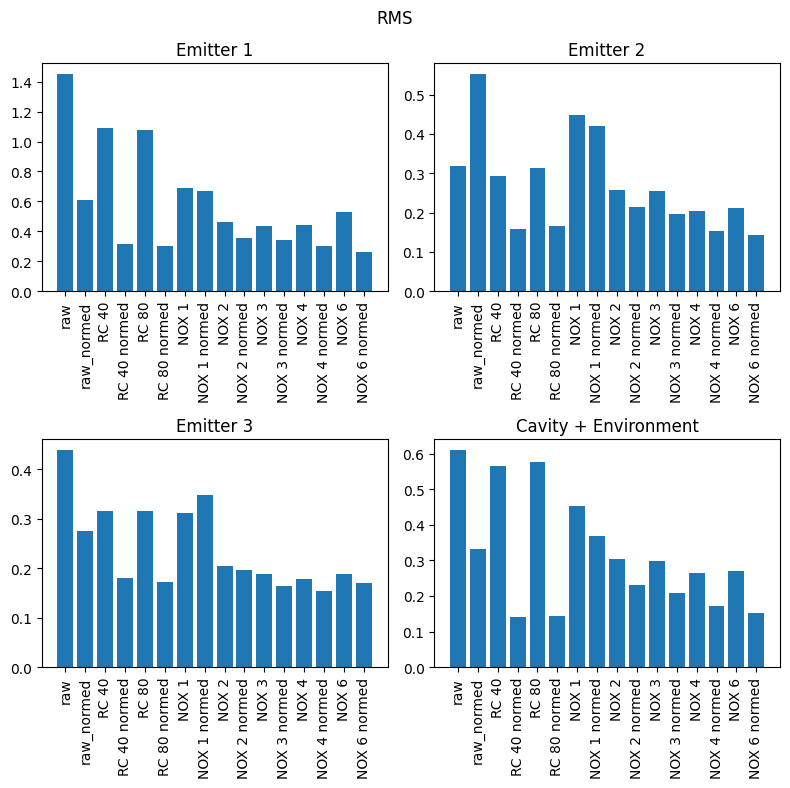

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

for col, ax in zip(all_rms, axes.flatten()):
    positions = np.arange(len(all_rms.index))
    ax.bar(positions, all_rms[col])
    
    ax.set_xticks(positions)
    ax.set_xticklabels(all_rms.index, rotation=90)

    ax.set_title(col)

fig.suptitle("RMS")
plt.tight_layout()

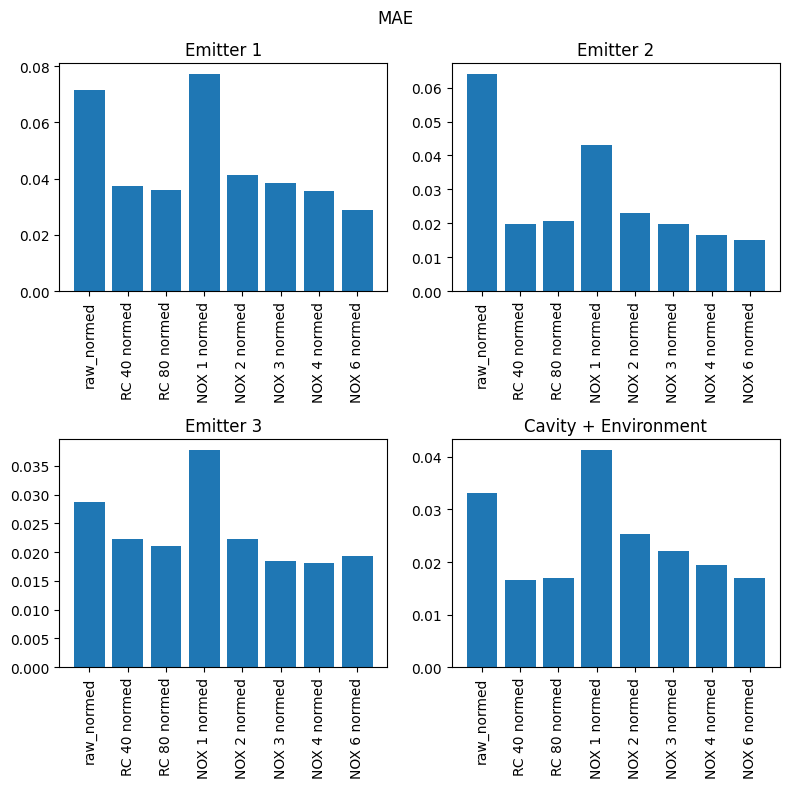

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

norm_rows = [r for r in all_mae.index if 'norm' in r]
norm_mae = all_mae.loc[norm_rows]

for col, ax in zip(all_mae, axes.flatten()):
    ax.bar(norm_rows, norm_mae[col])
    
    ax.set_xticks(np.arange(len(norm_mae)))
    ax.set_xticklabels(norm_mae.index, rotation=90)

    ax.set_title(col)

fig.suptitle("MAE")
plt.tight_layout()

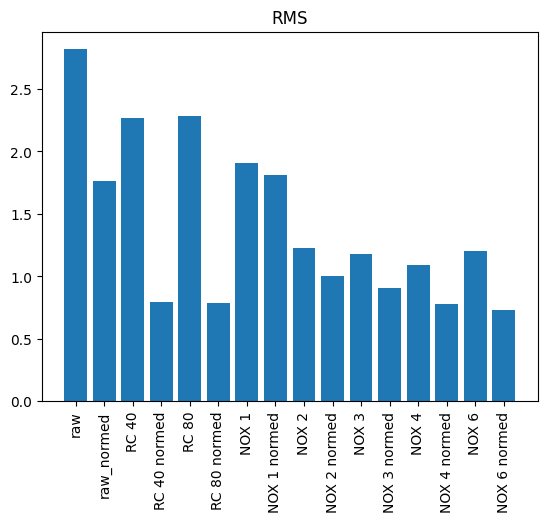

In [22]:
plt.bar(all_rms.index, all_rms.sum(axis=1))
plt.xticks(all_rms.index, rotation=90)
plt.title("RMS")
plt.show()

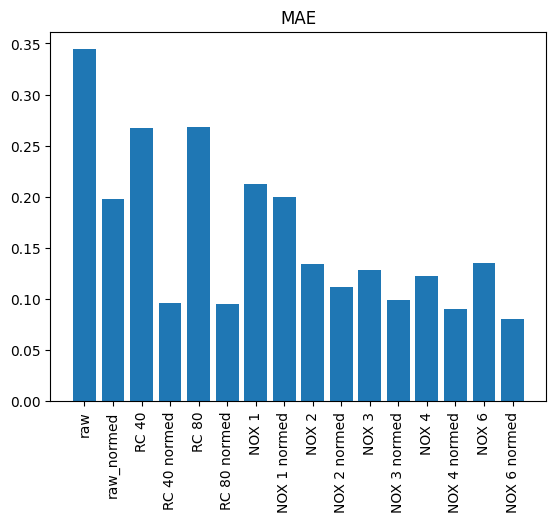

In [23]:
plt.bar(all_mae.index, all_mae.sum(axis=1))
plt.xticks(all_mae.index, rotation=90)
plt.title("MAE")
plt.show()

In [24]:
all_mae.sum(axis=1)

raw             0.344430
raw_normed      0.197469
RC 40           0.267319
RC 40 normed    0.095848
RC 80           0.268592
RC 80 normed    0.094802
NOX 1           0.212539
NOX 1 normed    0.199361
NOX 2           0.133972
NOX 2 normed    0.111868
NOX 3           0.128081
NOX 3 normed    0.099192
NOX 4           0.122090
NOX 4 normed    0.089878
NOX 6           0.134710
NOX 6 normed    0.080285
dtype: float64

In [25]:
all_rms.sum(axis=1)

raw             2.817631
raw_normed      1.765787
RC 40           2.262637
RC 40 normed    0.797413
RC 80           2.283189
RC 80 normed    0.783645
NOX 1           1.902964
NOX 1 normed    1.806531
NOX 2           1.226662
NOX 2 normed    0.999463
NOX 3           1.175497
NOX 3 normed    0.907955
NOX 4           1.089413
NOX 4 normed    0.781500
NOX 6           1.201654
NOX 6 normed    0.728626
dtype: float64